### Power Spectral Desnity with Scipy Periodogram

In [9]:
import scipy.signal
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import torch
sys.path.append("../")
sys.path.append("../data")
sys.path.append("../visualize")
sys.path.append("../models")
sys.path.append("../artifacts/")
from load_EEGs_mc import EEGDatasetMc
import stacklineplot
from constants import *
from models import *
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 4]

In [5]:
# first load some data
files_csv = "../data/dataset_csv/sample_file.csv"
dataset = EEGDatasetMc(files_csv, select_channels=list(range(4)), max_num_examples=100, length=784)
i = 0

In [311]:
i += 1
x = dataset[i][0].numpy()
fs = 200
f, Pxx_den = scipy.signal.periodogram(x, fs)

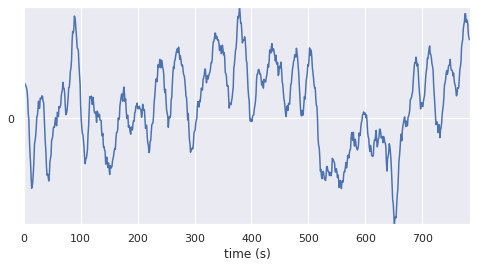

In [312]:
stacklineplot.stackplot(x.reshape(1, -1))

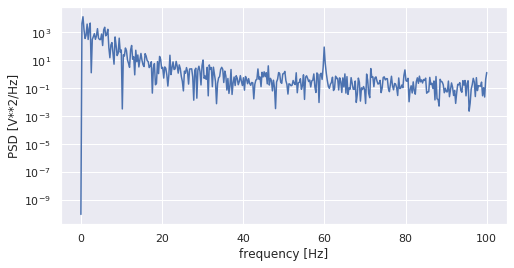

In [313]:
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### Add 60hz Noise

In [335]:
fs = fs # sample rate 
f = 60 # the frequency of the signal 
length = x.shape[0]
# noise = np.sin(2*np.pi*f * (np.arange(fs) /fs)) * 100
# noise = np.vstack((noise, noise, noise, noise)).reshape(-1)[:len(x)]
noise = np.sin(2*np.pi*f * (np.arange(length) / fs)) * 100

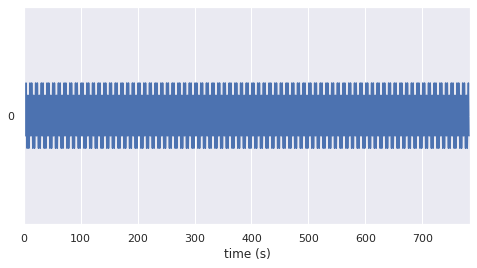

In [336]:
stacklineplot.stackplot(noise.reshape(1, -1), yscale=.3)

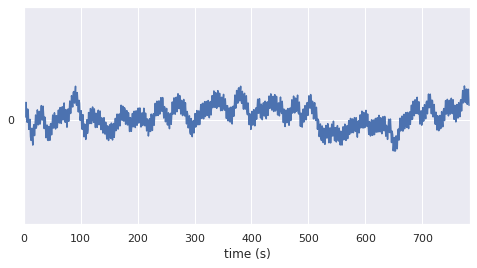

In [337]:
noisy_x = x + noise
stacklineplot.stackplot(noisy_x.reshape(1, -1), yscale=.3)

In [338]:
f, Pxx_den = scipy.signal.periodogram(noisy_x, fs)

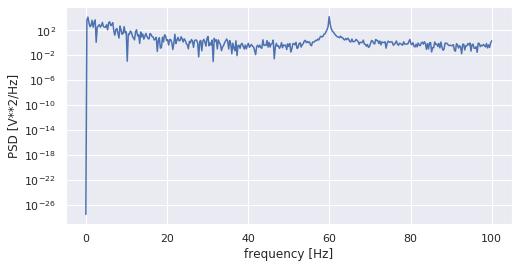

In [339]:
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# Notice the spike at 60hz

### Functions for metric_utils.py

In [32]:
def get_psd_diff(original, recon, fs=200):
    f, Pxx = scipy.signal.periodogram(np.vstack((original,recon)), fs)
    return np.sum(abs(Pxx[0] - Pxx[1])) / original.shape[-1]

In [33]:
def get_psd_dff_batch(original_batch, reconstructed_batch, fs=200):
    differences = []
    for orig, recon in zip(original_batch, reconstructed_batch):
        differences.append(get_psd_diff(orig, recon, fs=fs))
    return sum(differences) / len(differences)

### Evaluate Trained Model

In [34]:
import sys
sys.path.append("../models/")
sys.path.append("../models/vq-vae-2-pytorch/")
sys.path.append("../data/")
sys.path.append("../")

from load_EEGs_1c import EEGDataset1c
from load_EEGs_mc import EEGDatasetMc
from conv_VAE import ConvVAE
from VAE1c import VAE1c
from vqvae import VQVAE_2
from VQ_VAE_1c import VQVAE
from unet import UNet
from constants import *

In [ ]:
# model_filename = "../reconstruction/saved_runs/1593886455/model.pt" # VQ
model_filename = "../reconstruction/saved_runs/1593886568/model.pt" # NN
model = torch.load(model_filename)
model.eval()

In [36]:
dataset = EEGDataset1c(DEV_NORMAL_FILES_CSV, max_num_examples=40, length=784, normalize=True)

In [37]:
with torch.no_grad():
    diff = torch.zeros(393)
    original_total = np.zeros((393))
    recon_total = np.zeros((393))
    for x in dataset:
        out = model(x.cuda().view(1, -1))
        recon = out[0]
        f_x, psd_x = scipy.signal.periodogram(x.cpu().numpy(), 200)
        f_recon, psd_recon = scipy.signal.periodogram(recon.cpu().numpy(), 200)
        assert((f_x == f_recon).all())
        original_total += psd_x.reshape(-1)
        recon_total += psd_recon.reshape(-1)
        diff += abs(psd_x - psd_recon)

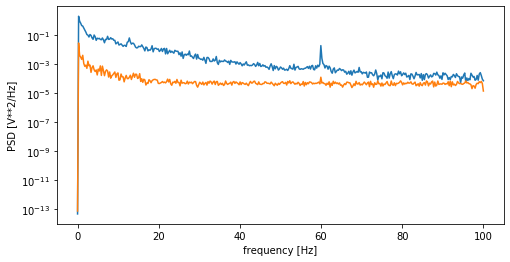

In [38]:
plt.semilogy(f_x, original_total)
plt.semilogy(f_x, recon_total)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# blue is orig
# orange is recon

difference in signals

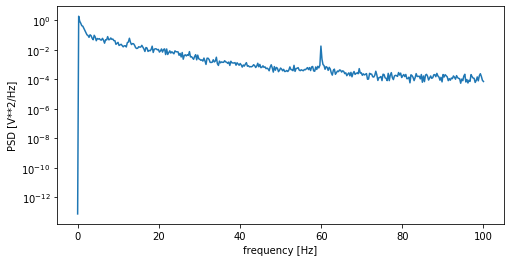

In [39]:
plt.semilogy(f_x, diff.view(-1))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### Difference in Signals by Model

In [83]:
def get_psd_diff(dataset, model_filename):
    model = torch.load(model_filename)
    model.eval()
    with torch.no_grad():
        diff = torch.zeros(393)
        original_total = np.zeros((393))
        recon_total = np.zeros((393))
        for x in dataset:
            out = model(x.cuda().view(1, -1))
            recon = out[0]
            f_x, psd_x = scipy.signal.periodogram(x.cpu().numpy(), 200)
            f_recon, psd_recon = scipy.signal.periodogram(recon.cpu().numpy(), 200)
            assert((f_x == f_recon).all())
            original_total += psd_x.reshape(-1)
            recon_total += psd_recon.reshape(-1)
            diff = np.vstack((diff, abs(psd_x - psd_recon)))
    return f_recon, diff[1:], original_total, recon_total

In [40]:
def get_psd_diff(dataset, model_filename):
    model = torch.load(model_filename)
    model.eval()
    with torch.no_grad():
        diff = torch.zeros(393)
        original_total = np.zeros((393))
        recon_total = np.zeros((393))
        for x in dataset:
            out = model(x.cuda().view(1, -1))
            recon = out[0]
            f_x, psd_x = scipy.signal.periodogram(x.cpu().numpy(), 200)
            f_recon, psd_recon = scipy.signal.periodogram(recon.cpu().numpy(), 200)
            assert((f_x == f_recon).all())
            original_total += psd_x.reshape(-1)
            recon_total += psd_recon.reshape(-1)
            diff += abs(psd_x - psd_recon)
    return f_recon, diff.view(-1), original_total, recon_total

In [277]:
import sklearn.preprocessing

In [341]:
nn_filename = "../reconstruction/saved_runs/1593886568/model.pt"
vq_filename = "../reconstruction/saved_runs/1593886455/model.pt"
# dataset = EEGDataset1c(DEV_NORMAL_FILES_CSV, max_num_examples=-1, length=784, normalize=True)
dataset = EEGDataset1c(TRAIN_NORMAL_FILES_CSV, max_num_examples=-1, length=784, normalize=True)
f, nn_diff, nn_original_total, nn_recon_total = get_psd_diff(dataset, nn_filename)
f, vq_diff, vq_original_total, vq_recon_total = get_psd_diff(dataset, vq_filename)
nn_diffs, vq_diffs = nn_diff, vq_diff
nn_diffs = sklearn.preprocessing.normalize(nn_diffs)
vq_diffs = sklearn.preprocessing.normalize(vq_diffs)

nn_diff, vq_diff = np.sum(nn_diff, axis=0).reshape(-1)/ nn_diff.shape[0], np.sum(vq_diff, axis=0).reshape(-1)/ vq_diff.shape[0]
nn_diff, vq_diff = torch.from_numpy(nn_diff), torch.from_numpy(vq_diff)

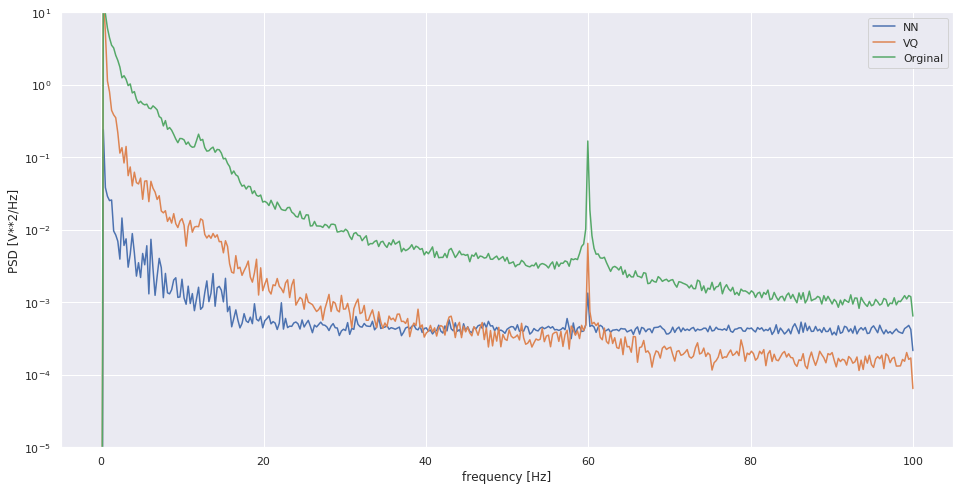

In [365]:
plt.rcParams['figure.figsize'] = [16, 8]

# multiply by factor to align with original
# plt.semilogy(f, nn_recon_total * 12, label="NN")
# plt.semilogy(f, vq_recon_total * 7.5, label="VQ")

plt.semilogy(f, nn_recon_total, label="NN")
plt.semilogy(f, vq_recon_total, label="VQ")
plt.semilogy(f, vq_original_total, label="Orginal")
plt.ylim([1e-5, 1e1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
leg = plt.legend()
plt.show()

In [281]:
mid = 100 + nn_diff.shape[0] // 2
print("NN Total Diff {:.3f}".format((torch.sum(nn_diff  / np.sum(vq_original_total)).item())))
print("VQ Total Diff {:.3f}".format((torch.sum(vq_diff  / np.sum(vq_original_total)).item())))
print("NN diff 0-50hz {:.3f}".format((torch.sum(nn_diff[:mid] / np.sum(vq_original_total[:mid])).item())))
print("VQ diff 0-50hz {:.3f}".format((torch.sum(vq_diff[:mid] / np.sum(vq_original_total[:mid])).item())))
print("NN diff 50-100hz {:.3f}".format((torch.sum(nn_diff[mid:] / np.sum(vq_original_total[mid:])).item())))
print("VQ diff 50-100hz {:.3f}".format((torch.sum(vq_diff[mid:] / np.sum(vq_original_total[mid:])).item())))

NN Total Diff 0.993
VQ Total Diff 0.734
NN diff 0-50hz 0.993
VQ diff 0-50hz 0.734
NN diff 50-100hz 0.910
VQ diff 50-100hz 0.908


In [282]:
nn_diff.shape

torch.Size([393])

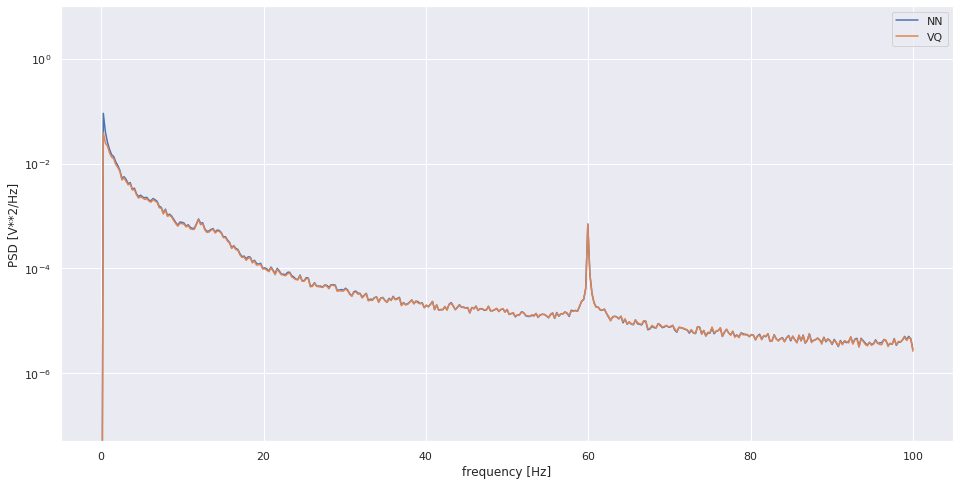

In [352]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.semilogy(f, abs(nn_diff), label="NN")
plt.semilogy(f, abs(vq_diff), label="VQ")
plt.ylim([5e-8, 1e1])
# plt.ylim([1e-4, 3e1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
leg = plt.legend()
plt.show()

### Violin Plots

In [162]:
d.shape

(393, 2)

In [163]:
import pandas as pd

In [164]:
d = np.vstack((nn_diff, vq_diff)).T
d = pd.DataFrame(d, columns=["nn", "vq"]) 

In [190]:
nn_diff_df = pd.DataFrame(nn_diff, columns=["periodogram_difference"])
nn_diff_df['model_type'] = 'nn'
vq_diff_df = pd.DataFrame(vq_diff, columns=["periodogram_difference"])
vq_diff_df['model_type'] = 'vq'
frames = [nn_diff_df, vq_diff_df]


In [236]:
data = pd.concat(frames)

In [237]:
data

,periodogram_difference,model_type
0,9.219441e-13,nn
1,2.154823e+01,nn
2,9.543288e+00,nn
3,6.031106e+00,nn
4,4.427889e+00,nn
...,...,...
388,1.152545e-03,vq
389,9.962631e-04,vq
390,1.133682e-03,vq
391,1.079196e-03,vq


In [238]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 1.7,8.27

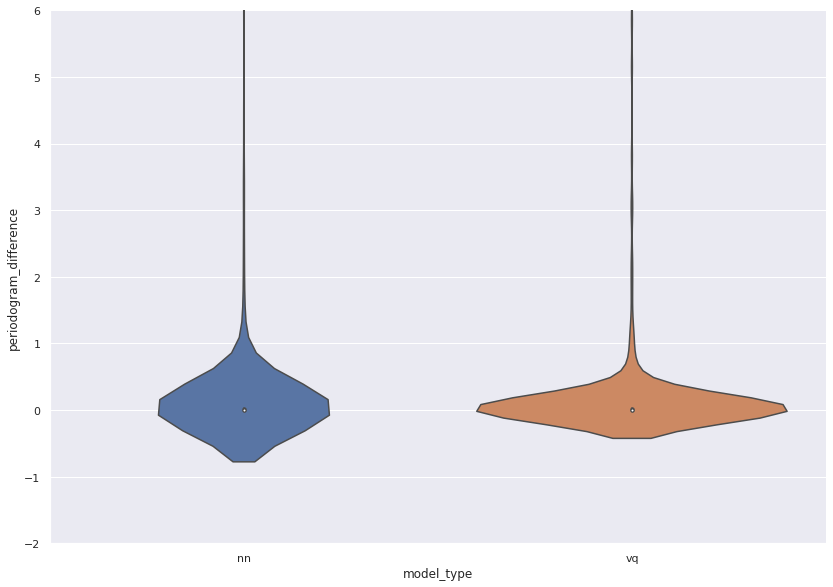

In [248]:
import seaborn as sns

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)
# Show each distribution with both violins and points
ax = sns.catplot(x="model_type", y="periodogram_difference",
            kind="violin", data=data, height=8.27, aspect=11.7/8.27);
ax.set(ylim=(-2, 6))